# Model Training & Testing
This notebook is intended to help train and test various models, and expanded from our data_model_prep notebook.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from fastai.tabular.all import *
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

import os
import pickle

random_state = 42
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Set up paths

In [2]:
# For python pipeline that will be run from root folder of project
# ROOT_DIR = os.path.abspath(os.curdir)

# # Pickle save paths
# training_df_path = os.path.join(ROOT_DIR,"data/processed/training_df.pkl")
# testing_df_path = os.path.join(ROOT_DIR,"data/processed/testing_df.pkl")

# Relative path for notebook
# training_df_path = "../data/processed/training_df.pkl"
testing_df_path = "../data/processed/testing_df.pkl"

# likedislike processed only
# training_df_path = "../data/processed/likedislike_withcomments_processed.pkl"

# Small df for testing with comments
training_df_path = "../data/processed/training_df_small_withcomments.pkl"

# Small df for testing
training_df_small_path = "../data/processed/training_df_small.pkl"
# Big df for testing
randompct10_pklpath=r"/run/user/1000/gvfs/smb-share:server=metebox,share=data/JAMES/datasets/youtube-meta/youtube-02-2019-dump/randompct_df_10.pkl"

## Load training and test dataframes

In [3]:
training_df = pd.read_pickle(training_df_path)
testing_df = pd.read_pickle(testing_df_path)

# big df
# training_df_big = pd.read_pickle(randompct10_pklpath)

# small df
# training_df = pd.read_pickle(training_df_small_path)

In [4]:
# Concat training df and training_df_big for testing if more data helps
# training_df = pd.concat([training_df,training_df_big])
# training_df = training_df.sample(frac=1).reset_index(drop=True)

In [42]:
def smooth_if_0(row):
    if row["like_count"] == 0:
        vl_ratio = (row["view_count"]+1) / (row["like_count"]+1)
    else:
        vl_ratio = row["view_count"] / row["like_count"]
    return round(vl_ratio,2)
    

In [45]:
# Smooth view_like ratio by adding 1 to test if that changes performance. Avoids division by 0.
training_df["view_like_ratio_smoothed"] = training_df.apply(lambda row: smooth_if_0(row),axis=1)
testing_df["view_like_ratio_smoothed"] = testing_df.apply(lambda row: smooth_if_0(row),axis=1)

In [47]:
training_df[["view_like_ratio","view_like_ratio_smoothed","view_count","like_count"]].head(5)

,view_like_ratio,view_like_ratio_smoothed,view_count,like_count
0,8.33,8.33,3380,406
1,256.29,256.29,1794,7
2,187.14,187.14,53708,287
3,6.10,6.10,17665,2896
4,0.00,12.00,11,0


In [32]:
training_df[["view_like_ratio","view_like_ratio_smoothed","view_count","like_count"]].head(5)

,view_like_ratio,view_like_ratio_smoothed,view_count,like_count
0,8.33,8.30,3380,406
1,256.29,224.40,1794,7


## Columns for model training

In [48]:
# Based on what we can get at inference time from the Youtube API or scraping
X_cols = [
    "duration",
    "age_limit",
    "view_count",
    "like_count",
#     "view_like_ratio",
    "view_like_ratio_smoothed",
    "is_comments_enabled",
    "is_live_content",
    "cat_codes",
#     "desc_neu",
#     "desc_neg",
#     "desc_pos",
    "desc_compound",
#     "comment_neu",
#     "comment_neg",
#     "comment_pos",
    "comment_compound",
    "votes"
]

y_col = "ld_score_ohe"

# Get all related columns - useful for fastai models
all_related_cols = X_cols.copy()
all_related_cols.append(y_col)

In [49]:
# Testing scaled versions
scaler = StandardScaler()
training_df_scaled_X = scaler.fit_transform(training_df[X_cols])
testing_df_scaled_X = scaler.transform(testing_df[X_cols])

## Helper Functions

In [50]:
def create_training_test_sets(df,X_cols,y_col,random_state=None):
    """
    Takes in a processed dataframe and splits it into appropriate training and test splits.
    """
    X = df[X_cols]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=random_state)
    print("Splits created")
    return X, y, X_train, X_test, y_train,y_test

def train_model(clf_object,model_name,X_train,y_train,X_test,y_test):
    clf_object.fit(X_train,y_train)
    acc, f1 = test_model_metrics(clf=clf_object,model_name=model_name)
    return clf_object, acc, f1

def test_model_metrics(clf, model_name,X_test,y_test):
    testpreds = clf.predict(X_test)
    acc = accuracy_score(y_test,testpreds)
    
    if len(y_test.unique()) > 2:
        average = "weighted"
    else:
        average = "binary"
        
    f1 = f1_score(y_test,testpreds,average=average)
    print(f"{model_name} metrics:")
    print(f"Accuracy Score: {acc}")
    print(f"F1 score: {f1}")
    return acc,f1

def cross_val_model(df,clf_object,X_cols,y_col,random_state,scoring,cv=5):
    """
    Takes in a df, processes it, and then outputs a cross-validation f1 score.
    Adapted from sklearn docs.
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    scores = cross_val_score(clf_object, X, y, cv=cv,scoring=scoring,verbose=1,n_jobs=-1)
    print(f"{scores.mean():0.2f} {scoring} with a standard deviation of {scores.std():0.2f}")
    return scores

def confusion_matrix_model(df,clf_object,X_cols,y_col,random_state,model_name):
    """
    Takes in a df, processes it, and then outputs a confusion matrix.
    Adapted from sklearn docs: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    clf_object.fit(X_train,y_train)
    
    # Adapted from sklearn docs
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        (f"{model_name} Confusion matrix, without normalization", None),
        (f"{model_name} Normalized confusion matrix", "true"),
    ]
    
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf_object,
            X_test,
            y_test,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

## Model Training

### Random Forest

In [51]:
# Training model
rf_clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
rf_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
rf_acc,rf_f1 = test_model_metrics(rf_clf,"Random Forest",testing_df[X_cols],testing_df[y_col])

Random Forest metrics:
Accuracy Score: 0.6423027966237843
F1 score: 0.6592976312347466


RF Confusion Matrix
[[0.88903894 0.02745892 0.08350214]
 [0.47956743 0.11469273 0.40573984]
 [0.3118142  0.00711859 0.68106721]]


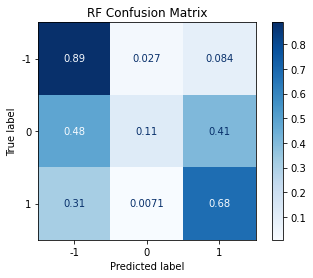

In [52]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix")

print("RF Confusion Matrix")
print(disp.confusion_matrix)

Random Forest-Scaled metrics:
Accuracy Score: 0.6422719015311608
F1 score: 0.6592258035331474
RF Confusion Matrix-Scaled
[[0.88903894 0.02745892 0.08350214]
 [0.4797754  0.1142768  0.4059478 ]
 [0.31183912 0.00706875 0.68109213]]


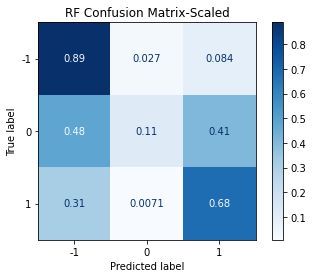

In [53]:
# Training model - scaled
rf_clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
rf_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
rf_acc,rf_f1 = test_model_metrics(rf_clf,"Random Forest-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix-Scaled")

print("RF Confusion Matrix-Scaled")
print(disp.confusion_matrix)

Random Forest metrics:
Accuracy Score: 0.6399733066399733
F1 score: 0.6569425053278282
RF Confusion Matrix
[[0.88917398 0.02610849 0.08471753]
 [0.48591037 0.10985754 0.40423209]
 [0.31408185 0.00723488 0.67868327]]


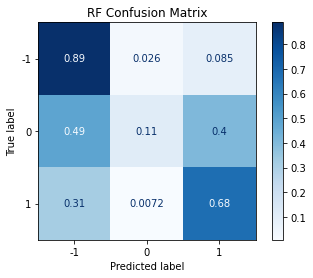

In [55]:
class_weight_dict = {-1:0.5,0:2,1:4}

# Training model
rf_clf = RandomForestClassifier(
    n_jobs=-1,
    random_state=random_state,
    class_weight = class_weight_dict,
#     max_depth=64,
# The below are good without class weights
#     min_samples_split=0.01,
#     min_samples_leaf=0.05,
#     max_depth=8,
    )
rf_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
rf_acc,rf_f1 = test_model_metrics(rf_clf,"Random Forest",testing_df[X_cols],testing_df[y_col])
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix")

print("RF Confusion Matrix")
print(disp.confusion_matrix)

### GBM

In [56]:
# Training model
# Params Based on previous gridsearch cvs
gbm_model = lgb.LGBMClassifier(learning_rate=0.05,
                               max_depth=20,
                               min_child_samples=15,
                               num_leaves=100,
                               reg_alpha=0.03,
                               random_state=random_state)
gbm_model.fit(training_df[X_cols],training_df[y_col], verbose=20,eval_metric='logloss')

# Testing model
gbm_acc,gbm_f1 = test_model_metrics(gbm_model,"GBM",testing_df[X_cols],testing_df[y_col])

GBM metrics:
Accuracy Score: 0.646109072034998
F1 score: 0.6593052590849785


GBM Confusion Matrix
[[8.90704479e-01 2.15169930e-02 8.77785280e-02]
 [4.76136009e-01 9.44161381e-02 4.29447853e-01]
 [3.10161227e-01 7.22657386e-04 6.89116115e-01]]


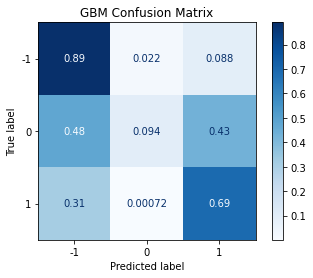

In [57]:
disp = ConfusionMatrixDisplay.from_estimator(
    gbm_model,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("GBM Confusion Matrix")

print("GBM Confusion Matrix")
print(disp.confusion_matrix)

GBM-Scaled metrics:
Accuracy Score: 0.6459731336274546
F1 score: 0.6589998832172455
GBM Confusion Matrix-Scaled
[[8.91604772e-01 2.12018906e-02 8.71933378e-02]
 [4.80035354e-01 9.21805137e-02 4.27784132e-01]
 [3.10128002e-01 7.47576606e-04 6.89124422e-01]]


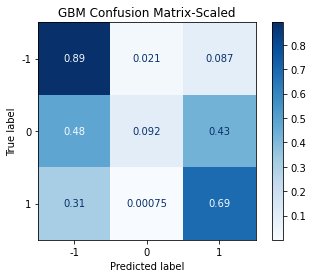

In [58]:
# Training model - scaled version
# Params Based on previous gridsearch cvs
gbm_model = lgb.LGBMClassifier(learning_rate=0.05,
                               max_depth=20,
                               min_child_samples=15,
                               num_leaves=100,
                               reg_alpha=0.03,
                               random_state=random_state)
gbm_model.fit(training_df_scaled_X,training_df[y_col], verbose=20,eval_metric='logloss')

# Testing model
gbm_acc,gbm_f1 = test_model_metrics(gbm_model,"GBM-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    gbm_model,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("GBM Confusion Matrix-Scaled")

print("GBM Confusion Matrix-Scaled")
print(disp.confusion_matrix)

### Neural Net
We will use sklearn mlp and fastai to create a tabular learner neural net

Iteration 1, loss = 3.66438556
Iteration 2, loss = 3.54408755
Iteration 3, loss = 3.13286018
Iteration 4, loss = 3.30536573
Iteration 5, loss = 2.99156791
Iteration 6, loss = 2.99865823
Iteration 7, loss = 2.87969024
Iteration 8, loss = 2.85567691
Iteration 9, loss = 2.80016096
Iteration 10, loss = 3.03667147
Iteration 11, loss = 2.74064644
Iteration 12, loss = 2.76742595
Iteration 13, loss = 3.05556528
Iteration 14, loss = 2.79942735
Iteration 15, loss = 3.01989315
Iteration 16, loss = 3.02477163
Iteration 17, loss = 3.07936507
Iteration 18, loss = 2.94051255
Iteration 19, loss = 2.90007679
Iteration 20, loss = 3.12330087
Iteration 21, loss = 3.14555594
Iteration 22, loss = 2.99393566
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLP metrics:
Accuracy Score: 0.6375882054894401
F1 score: 0.6614146370902487
MLP Confusion Matrix
[[0.86203016 0.04938105 0.08858879]
 [0.6446397  0.10216284 0.25319746]
 [0.24913406 0.06915084 0.68171511]]
CPU time

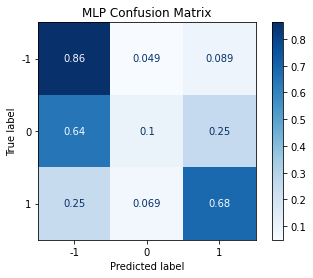

In [59]:
%%time
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, max_iter=300, verbose=2)
mlp_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
mlp_acc,mlp_f1 = test_model_metrics(mlp_clf,"MLP",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix")

print("MLP Confusion Matrix")
print(disp.confusion_matrix)

In [195]:
def remap_target(value):
    if value == -1:
        return "Negative"
    elif value == 0:
        return "Neutral"
    elif value == 1:
        return "Positive"

In [37]:
mlp_scaled_best_params

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (10, 10, 10),
 'learning_rate': 'constant'}

#### MLP

In [ ]:
%%time
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, 
                        max_iter=300, 
                        verbose=2,
                        activation="relu",
                        hidden_layer_sizes=(5,3,),
                        learning_rate="adaptive",
                        alpha=0.0001)

mlp_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
mlp_acc,mlp_f1 = test_model_metrics(mlp_clf,"MLP-BestParams",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-BestParams")

print("MLP Confusion Matrix-BestParams")
print(disp.confusion_matrix)

Iteration 1, loss = 0.65909687
Iteration 2, loss = 0.39678566
Iteration 3, loss = 0.38150078
Iteration 4, loss = 0.38007179
Iteration 5, loss = 0.38013141
Iteration 6, loss = 0.36632018
Iteration 7, loss = 0.34526975
Iteration 8, loss = 0.31913522
Iteration 9, loss = 0.28969150
Iteration 10, loss = 0.36281543
Iteration 11, loss = 0.30733309
Iteration 12, loss = 0.33821705
Iteration 13, loss = 0.29039501
Iteration 14, loss = 0.29838711
Iteration 15, loss = 0.26005249
Iteration 16, loss = 0.28385491
Iteration 17, loss = 0.26207056
Iteration 18, loss = 0.26049553
Iteration 19, loss = 0.29287013
Iteration 20, loss = 0.28642488
Iteration 21, loss = 0.25569598
Iteration 22, loss = 0.26283006
Iteration 23, loss = 0.26713178
Iteration 24, loss = 0.26558052
Iteration 25, loss = 0.28093716
Iteration 26, loss = 0.25200414
Iteration 27, loss = 0.27285981
Iteration 28, loss = 0.25286581
Iteration 29, loss = 0.25029781
Iteration 30, loss = 0.25511140
Iteration 31, loss = 0.26415123
Iteration 32, los

#### MLP with Scaled X

In [ ]:
%%time
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, 
                        max_iter=300, 
                        verbose=2,
                        activation="relu",
                        hidden_layer_sizes=(5,3,),
                        learning_rate="adaptive",
                        alpha=0.0001)

mlp_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
mlp_acc,mlp_f1 = test_model_metrics(mlp_clf,"MLP-BestParams-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-BestParams-Scaled")

print("MLP Confusion Matrix-BestParams-Scaled")
print(disp.confusion_matrix)

Iteration 1, loss = 0.52888149
Iteration 2, loss = 0.45452839
Iteration 3, loss = 0.43503824
Iteration 4, loss = 0.42217512
Iteration 5, loss = 0.41280090
Iteration 6, loss = 0.40462974
Iteration 7, loss = 0.39753161
Iteration 8, loss = 0.38915297
Iteration 9, loss = 0.38123902
Iteration 10, loss = 0.37458984
Iteration 11, loss = 0.36895252
Iteration 12, loss = 0.36397631
Iteration 13, loss = 0.35963411
Iteration 14, loss = 0.35531498
Iteration 15, loss = 0.35205756
Iteration 16, loss = 0.34842535
Iteration 17, loss = 0.34576676
Iteration 18, loss = 0.34285251
Iteration 19, loss = 0.34089546
Iteration 20, loss = 0.33869156
Iteration 21, loss = 0.33695216
Iteration 22, loss = 0.33499959
Iteration 23, loss = 0.33353915
Iteration 24, loss = 0.33181305
Iteration 25, loss = 0.32977335
Iteration 26, loss = 0.32894643
Iteration 27, loss = 0.32776113
Iteration 28, loss = 0.32671537
Iteration 29, loss = 0.32560771
Iteration 30, loss = 0.32408620
Iteration 31, loss = 0.32290429
Iteration 32, los

Iteration 253, loss = 0.29106422
Iteration 254, loss = 0.29083931
Iteration 255, loss = 0.29093415
Iteration 256, loss = 0.29077275
Iteration 257, loss = 0.29095828
Iteration 258, loss = 0.29068945
Iteration 259, loss = 0.29043570
Iteration 260, loss = 0.29064498
Iteration 261, loss = 0.29039395
Iteration 262, loss = 0.29096491
Iteration 263, loss = 0.29039398
Iteration 264, loss = 0.29034399
Iteration 265, loss = 0.29036935
Iteration 266, loss = 0.28994328
Iteration 267, loss = 0.28975751
Iteration 268, loss = 0.29016122
Iteration 269, loss = 0.29005193
Iteration 270, loss = 0.28985348
Iteration 271, loss = 0.29003092
Iteration 272, loss = 0.28978113
Iteration 273, loss = 0.29058611
Iteration 274, loss = 0.28987994
Iteration 275, loss = 0.29013931
Iteration 276, loss = 0.29024714
Iteration 277, loss = 0.28943902
Iteration 278, loss = 0.28980867
Iteration 279, loss = 0.28947305
Iteration 280, loss = 0.28994736
Iteration 281, loss = 0.28951315
Iteration 282, loss = 0.29001049
Iteration 

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Confusion Matrix-scaled
[[8.08327707e-01 1.12536574e-03 1.90546928e-01]
 [4.47436831e-01 5.45908287e-03 5.47104087e-01]
 [1.12585037e-01 7.97415046e-04 8.86617548e-01]]
CPU times: user 1h 51min 17s, sys: 4min 38s, total: 1h 55min 56s
Wall time: 19min 20s


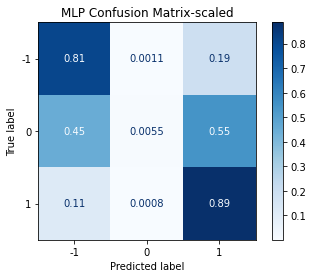

In [32]:
%%time 
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, max_iter=300, verbose=10)
mlp_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
mlp_acc,mlp_f1 = test_model_metrics(mlp_clf,"MLP-scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-scaled")

print("MLP Confusion Matrix-scaled")
print(disp.confusion_matrix)

Iteration 1, loss = 0.40701400
Iteration 2, loss = 0.31252940
Iteration 3, loss = 0.30277185
Iteration 4, loss = 0.30906611
Iteration 5, loss = 0.29275641
Iteration 6, loss = 0.28824150
Iteration 7, loss = 0.28439195
Iteration 8, loss = 0.29689165
Iteration 9, loss = 0.27265937
Iteration 10, loss = 0.28276546
Iteration 11, loss = 0.28344491
Iteration 12, loss = 0.30125225
Iteration 13, loss = 0.28142215
Iteration 14, loss = 0.27446613
Iteration 15, loss = 0.27726245
Iteration 16, loss = 0.27750526
Iteration 17, loss = 0.27472576
Iteration 18, loss = 0.29798478
Iteration 19, loss = 0.27344115
Iteration 20, loss = 0.27723733
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.33151311
Iteration 2, loss = 0.28947453
Iteration 3, loss = 0.27905612
Iteration 4, loss = 0.27487679
Iteration 5, loss = 0.27349553
Iteration 6, loss = 0.27349734
Iteration 7, loss = 0.26545096
Iteration 8, loss = 0.26780056
Iteration 9, loss = 0.27019535


Iteration 5, loss = 0.29190243Iteration 1, loss = 0.45841544
Iteration 2, loss = 0.34654656
Iteration 3, loss = 0.31394718
Iteration 4, loss = 0.28977850
Iteration 5, loss = 0.29568180
Iteration 6, loss = 0.31243977
Iteration 7, loss = 0.30642095
Iteration 8, loss = 0.29913575
Iteration 9, loss = 0.29182255
Iteration 10, loss = 0.29886972
Iteration 11, loss = 0.29874969
Iteration 12, loss = 0.28401646
Iteration 13, loss = 0.28735091
Iteration 14, loss = 0.29277096
Iteration 15, loss = 0.28090091
Iteration 16, loss = 0.28376037
Iteration 17, loss = 0.29561624
Iteration 18, loss = 0.27745587
Iteration 19, loss = 0.27463096
Iteration 20, loss = 0.27954703
Iteration 21, loss = 0.28071557
Iteration 22, loss = 0.27581267
Iteration 23, loss = 0.28211803
Iteration 24, loss = 0.27460174
Iteration 25, loss = 0.27419507
Iteration 26, loss = 0.28064788
Iteration 27, loss = 0.27651367
Iteration 28, loss = 0.27514478
Iteration 29, loss = 0.27130439
Iteration 30, loss = 0.26952141
Iteration 31, loss 

Iteration 1, loss = 0.45841544
Iteration 2, loss = 0.34654656
Iteration 3, loss = 0.31394718
Iteration 4, loss = 0.28977850
Iteration 5, loss = 0.29568180
Iteration 6, loss = 0.31243977
Iteration 7, loss = 0.30642095
Iteration 8, loss = 0.29913575
Iteration 9, loss = 0.29182255
Iteration 10, loss = 0.29886972
Iteration 11, loss = 0.29874969
Iteration 12, loss = 0.28401646
Iteration 13, loss = 0.28735091
Iteration 14, loss = 0.29277096
Iteration 15, loss = 0.28090091
Iteration 16, loss = 0.28376037
Iteration 17, loss = 0.29561624
Iteration 18, loss = 0.27745587
Iteration 19, loss = 0.27463096
Iteration 20, loss = 0.27954703
Iteration 21, loss = 0.28071557
Iteration 22, loss = 0.27581267
Iteration 23, loss = 0.28211803
Iteration 24, loss = 0.27460174
Iteration 25, loss = 0.27419507
Iteration 26, loss = 0.28064788
Iteration 27, loss = 0.27651367
Iteration 28, loss = 0.27514478
Iteration 29, loss = 0.27130439
Iteration 30, loss = 0.26952141
Iteration 31, loss = 0.27813779
Iteration 32, los

Iteration 1, loss = 0.39242055
Iteration 2, loss = 0.31204405
Iteration 3, loss = 0.28957022
Iteration 4, loss = 0.29374337
Iteration 5, loss = 0.29989757
Iteration 6, loss = 0.29258826
Iteration 7, loss = 0.28457235
Iteration 8, loss = 0.29022549
Iteration 9, loss = 0.28188179
Iteration 10, loss = 0.26999265
Iteration 11, loss = 0.27272760
Iteration 12, loss = 0.27325180
Iteration 13, loss = 0.27196838
Iteration 14, loss = 0.28348588
Iteration 15, loss = 0.27541411
Iteration 16, loss = 0.27938415
Iteration 17, loss = 0.26783011
Iteration 18, loss = 0.26672062
Iteration 19, loss = 0.27240025
Iteration 20, loss = 0.27135273
Iteration 21, loss = 0.27228484
Iteration 22, loss = 0.27035860
Iteration 23, loss = 0.27653132
Iteration 24, loss = 0.26120957
Iteration 25, loss = 0.27231464
Iteration 26, loss = 0.26824774
Iteration 27, loss = 0.26252530
Iteration 28, loss = 0.27605703
Iteration 29, loss = 0.27084002
Iteration 30, loss = 0.26141037
Iteration 31, loss = 0.27804010
Iteration 32, los

Iteration 1, loss = 0.43228643
Iteration 2, loss = 0.32308270
Iteration 3, loss = 0.31103518
Iteration 4, loss = 0.31969680
Iteration 5, loss = 0.31817753
Iteration 6, loss = 0.29652956
Iteration 7, loss = 0.28340677
Iteration 8, loss = 0.28506687
Iteration 9, loss = 0.29999942
Iteration 10, loss = 0.29030464
Iteration 11, loss = 0.28989360
Iteration 12, loss = 0.28486162
Iteration 13, loss = 0.28209297
Iteration 14, loss = 0.28262956
Iteration 15, loss = 0.27798160
Iteration 16, loss = 0.27096726
Iteration 17, loss = 0.26611379
Iteration 18, loss = 0.28328057
Iteration 19, loss = 0.26881195
Iteration 20, loss = 0.27464903
Iteration 21, loss = 0.27106633
Iteration 22, loss = 0.26892023
Iteration 23, loss = 0.27653037
Iteration 24, loss = 0.27241722
Iteration 25, loss = 0.26666767
Iteration 26, loss = 0.26336568
Iteration 27, loss = 0.27374789
Iteration 28, loss = 0.27803383
Iteration 29, loss = 0.27297842
Iteration 30, loss = 0.27108207
Iteration 31, loss = 0.26726562
Iteration 32, los

Iteration 1, loss = 0.42151894
Iteration 2, loss = 0.34186727
Iteration 3, loss = 0.31679228
Iteration 4, loss = 0.30287305
Iteration 5, loss = 0.29309950
Iteration 6, loss = 0.28576152
Iteration 7, loss = 0.28978015
Iteration 8, loss = 0.28198268
Iteration 9, loss = 0.28089363
Iteration 10, loss = 0.27712700
Iteration 11, loss = 0.27628600
Iteration 12, loss = 0.29583465
Iteration 13, loss = 0.28339407
Iteration 14, loss = 0.28101336
Iteration 15, loss = 0.27754933
Iteration 16, loss = 0.27840929
Iteration 17, loss = 0.28164941
Iteration 18, loss = 0.28252430
Iteration 19, loss = 0.27841760
Iteration 20, loss = 0.28397716
Iteration 21, loss = 0.27713089
Iteration 22, loss = 0.27606080
Iteration 23, loss = 0.27220012
Iteration 24, loss = 0.26823327
Iteration 25, loss = 0.27431739
Iteration 26, loss = 0.26965281
Iteration 27, loss = 0.26360360
Iteration 28, loss = 0.26928454
Iteration 29, loss = 0.26748154
Iteration 30, loss = 0.26909094
Iteration 31, loss = 0.26898226
Iteration 32, los

Iteration 1, loss = 0.39242055
Iteration 2, loss = 0.31204405
Iteration 3, loss = 0.28957022
Iteration 4, loss = 0.29374337
Iteration 5, loss = 0.29989757
Iteration 6, loss = 0.29258826
Iteration 7, loss = 0.28457235
Iteration 8, loss = 0.29022549
Iteration 9, loss = 0.28188179
Iteration 10, loss = 0.26999265
Iteration 11, loss = 0.27272760
Iteration 12, loss = 0.27325180
Iteration 13, loss = 0.27196838
Iteration 14, loss = 0.28348588
Iteration 15, loss = 0.27541411
Iteration 16, loss = 0.27938415
Iteration 17, loss = 0.26783011
Iteration 18, loss = 0.26672062
Iteration 19, loss = 0.27240025
Iteration 20, loss = 0.27135273
Iteration 21, loss = 0.27228484
Iteration 22, loss = 0.27035860
Iteration 23, loss = 0.27653132
Iteration 24, loss = 0.26120957
Iteration 25, loss = 0.27231464
Iteration 26, loss = 0.26824774
Iteration 27, loss = 0.26252530
Iteration 28, loss = 0.27605703
Iteration 29, loss = 0.27084002
Iteration 30, loss = 0.26141037
Iteration 31, loss = 0.27804010
Iteration 32, los

Iteration 20, loss = 0.28042078
Iteration 21, loss = 0.27569442
Iteration 22, loss = 0.27933167
Iteration 23, loss = 0.27792424
Iteration 24, loss = 0.27968770
Iteration 25, loss = 0.27708390
Iteration 26, loss = 0.28308456
Iteration 27, loss = 0.28120179
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.26128764
Iteration 2, loss = 1.03597093
Iteration 3, loss = 0.63149425
Iteration 4, loss = 0.59722453
Iteration 5, loss = 0.59435127
Iteration 6, loss = 0.58778426
Iteration 7, loss = 0.58463501
Iteration 8, loss = 0.56724102
Iteration 9, loss = 0.57630242
Iteration 10, loss = 0.57626226
Iteration 11, loss = 0.55846420
Iteration 12, loss = 0.54905214
Iteration 13, loss = 0.56347716
Iteration 14, loss = 0.56043639
Iteration 15, loss = 0.46378976
Iteration 16, loss = 0.41582934
Iteration 17, loss = 0.41831270
Iteration 18, loss = 0.39833979
Iteration 19, loss = 0.39844558
Iteration 20, loss = 0.42383444
Iteration 21, loss = 0.

Iteration 48, loss = 0.28155430
Iteration 49, loss = 0.27600521
Iteration 50, loss = 0.26775796
Iteration 51, loss = 0.26161241
Iteration 52, loss = 0.28481188
Iteration 53, loss = 0.29014417
Iteration 54, loss = 0.27205913
Iteration 55, loss = 0.26466583
Iteration 56, loss = 0.25918039
Iteration 57, loss = 0.26151096
Iteration 58, loss = 0.26228186
Iteration 59, loss = 0.26331525
Iteration 60, loss = 0.25875009
Iteration 61, loss = 0.25641850
Iteration 62, loss = 0.26125741
Iteration 63, loss = 0.26637000
Iteration 64, loss = 0.26322905
Iteration 65, loss = 0.25856132
Iteration 66, loss = 0.25992137
Iteration 67, loss = 0.26505743
Iteration 68, loss = 0.25805234
Iteration 69, loss = 0.26054176
Iteration 70, loss = 0.25538632
Iteration 71, loss = 0.26537055
Iteration 72, loss = 0.25992874
Iteration 73, loss = 0.26612860
Iteration 74, loss = 0.25960155
Iteration 75, loss = 0.25761366
Iteration 76, loss = 0.25550727
Iteration 77, loss = 0.26007770
Iteration 78, loss = 0.26051240
Iteratio

Iteration 4, loss = 0.51532897
Iteration 5, loss = 0.45662602
Iteration 6, loss = 0.44074748
Iteration 7, loss = 0.38952303
Iteration 8, loss = 0.35552700
Iteration 9, loss = 0.37544397
Iteration 10, loss = 0.36104833
Iteration 11, loss = 0.34926239
Iteration 12, loss = 0.35322118
Iteration 13, loss = 0.34761807
Iteration 14, loss = 0.37255946
Iteration 15, loss = 0.33101116
Iteration 16, loss = 0.31430193
Iteration 17, loss = 0.32052047
Iteration 18, loss = 0.30944213
Iteration 19, loss = 0.30697693
Iteration 20, loss = 0.33581713
Iteration 21, loss = 0.33031619
Iteration 22, loss = 0.32358899
Iteration 23, loss = 0.31380988
Iteration 24, loss = 0.30066387
Iteration 25, loss = 0.28981257
Iteration 26, loss = 0.31025298
Iteration 27, loss = 0.29804076
Iteration 28, loss = 0.29650502
Iteration 29, loss = 0.29480945
Iteration 30, loss = 0.28688976
Iteration 31, loss = 0.28709372
Iteration 32, loss = 0.27866164
Iteration 33, loss = 0.27312111
Iteration 34, loss = 0.31659889
Iteration 35, 

Iteration 23, loss = 0.28182723
Iteration 24, loss = 0.27821578
Iteration 25, loss = 0.28814125
Iteration 26, loss = 0.28696574
Iteration 27, loss = 0.27912478
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.54433163
Iteration 2, loss = 1.23369870
Iteration 3, loss = 0.54347917
Iteration 4, loss = 0.46718929
Iteration 5, loss = 0.44809008
Iteration 6, loss = 0.40219987
Iteration 7, loss = 0.43904978
Iteration 8, loss = 0.36968434
Iteration 9, loss = 0.35539988
Iteration 10, loss = 0.33723355
Iteration 11, loss = 0.37337154
Iteration 12, loss = 0.32009673
Iteration 13, loss = 0.36363730
Iteration 14, loss = 0.32885513
Iteration 15, loss = 0.33645709
Iteration 16, loss = 0.33316510
Iteration 17, loss = 0.35240865
Iteration 18, loss = 0.33077383
Iteration 19, loss = 0.34145935
Iteration 20, loss = 0.34463674
Iteration 21, loss = 0.34317202
Iteration 22, loss = 0.32428196
Iteration 23, loss = 0.30767372
Iteration 24, loss = 0.

Iteration 38, loss = 3.01954100
Iteration 39, loss = 2.71593628
Iteration 40, loss = 2.99600454
Iteration 41, loss = 2.97198114
Iteration 42, loss = 3.21064866
Iteration 43, loss = 3.11409320
Iteration 44, loss = 3.20966350
Iteration 45, loss = 2.89522614
Iteration 46, loss = 3.17020376
Iteration 47, loss = 3.09535598
Iteration 48, loss = 3.06522461
Iteration 49, loss = 3.12517354
Iteration 50, loss = 2.85844845
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.26128764
Iteration 2, loss = 1.03597093
Iteration 3, loss = 0.63149425
Iteration 4, loss = 0.59722453
Iteration 5, loss = 0.59435127
Iteration 6, loss = 0.58778426
Iteration 7, loss = 0.58463501
Iteration 8, loss = 0.56724102
Iteration 9, loss = 0.57630242
Iteration 10, loss = 0.57626226
Iteration 11, loss = 0.55846420
Iteration 12, loss = 0.54905214
Iteration 13, loss = 0.563477

Iteration 1, loss = 2.56605442
Iteration 2, loss = 1.07074700
Iteration 3, loss = 0.46292353
Iteration 4, loss = 0.40393295
Iteration 5, loss = 0.37326466
Iteration 6, loss = 0.33711878
Iteration 7, loss = 0.33769246
Iteration 8, loss = 0.34503669
Iteration 9, loss = 0.33290654
Iteration 10, loss = 0.32389803
Iteration 11, loss = 0.32224167
Iteration 12, loss = 0.30627045
Iteration 13, loss = 0.30285902
Iteration 14, loss = 0.30704280
Iteration 15, loss = 0.30248151
Iteration 16, loss = 0.29078148
Iteration 17, loss = 0.30065069
Iteration 18, loss = 0.30811866
Iteration 19, loss = 0.31075496
Iteration 20, loss = 0.29370550
Iteration 21, loss = 0.28932057
Iteration 22, loss = 0.31667767
Iteration 23, loss = 0.28917095
Iteration 24, loss = 0.29381728
Iteration 25, loss = 0.30530100
Iteration 26, loss = 0.30034973
Iteration 27, loss = 0.27716184
Iteration 28, loss = 0.28090427
Iteration 29, loss = 0.27790793
Iteration 30, loss = 0.27939208
Iteration 31, loss = 0.27257999
Iteration 32, los

Iteration 76, loss = 0.25320183
Iteration 77, loss = 0.25100673
Iteration 78, loss = 0.24707538
Iteration 79, loss = 0.24724871
Iteration 80, loss = 0.24598297
Iteration 81, loss = 0.24631310
Iteration 82, loss = 0.25814868
Iteration 83, loss = 0.25727503
Iteration 84, loss = 0.24900450
Iteration 85, loss = 0.25339651
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLP Scaled Best Params found through grid search cv are:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'constant'}
MLP-Gridsearch metrics:
Accuracy Score: 0.828581668087841
F1 score: 0.799191976639672
MLP Confusion Matrix-Gridsearch
[[8.37722260e-01 3.63718208e-02 1.25905919e-01]
 [3.15690964e-01 1.13652906e-01 5.70656130e-01]
 [5.88176661e-02 6.64512539e-05 9.41115883e-01]]


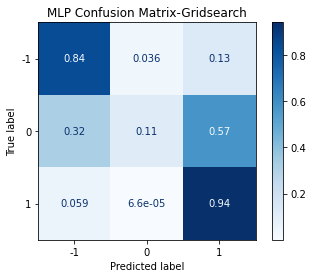

Iteration 32, loss = 0.26922311
Iteration 33, loss = 0.27111372
Iteration 34, loss = 0.27848335
Iteration 35, loss = 0.26453662
Iteration 36, loss = 0.27167554
Iteration 37, loss = 0.27504083
Iteration 38, loss = 0.27304957
Iteration 39, loss = 0.26102637
Iteration 40, loss = 0.26355637
Iteration 41, loss = 0.25886670
Iteration 42, loss = 0.27197636
Iteration 43, loss = 0.26509269
Iteration 44, loss = 0.27040923
Iteration 45, loss = 0.26027314
Iteration 46, loss = 0.26578179
Iteration 47, loss = 0.26304403
Iteration 48, loss = 0.27098182
Iteration 49, loss = 0.25686861
Iteration 50, loss = 0.25887245
Iteration 51, loss = 0.26960251
Iteration 52, loss = 0.27005669
Iteration 53, loss = 0.25519648
Iteration 54, loss = 0.26327628
Iteration 55, loss = 0.25664010
Iteration 56, loss = 0.26070010
Iteration 57, loss = 0.25805642
Iteration 58, loss = 0.25466238
Iteration 59, loss = 0.27238738
Iteration 60, loss = 0.25996688
Iteration 61, loss = 0.26579419
Iteration 62, loss = 0.26373347
Iteratio

In [35]:
# Gridsearch MLP
# Inspired by https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa
parameter_space = {
    'hidden_layer_sizes': [(10,10,10),(10,25,10),(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_base = MLPClassifier(random_state=random_state, max_iter=300, verbose=10)
mlp_clf_grid = GridSearchCV(mlp_base, parameter_space, n_jobs=-1, cv=3)
mlp_clf_grid.fit(training_df[X_cols],training_df[y_col])

mlp_scaled_best_params = mlp_clf_grid.best_params_
print("MLP Scaled Best Params found through grid search cv are:")
print(mlp_scaled_best_params)

# Testing model
mlp_acc_grid,mlp_f1_grid = test_model_metrics(mlp_clf_grid,"MLP-Gridsearch",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf_grid,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-Gridsearch")

print("MLP Confusion Matrix-Gridsearch")
print(disp.confusion_matrix)


In [36]:
mlp_scaled_best_params

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (10, 10, 10),
 'learning_rate': 'constant'}

In [ ]:
MLP Scaled Best Params found through grid search cv are:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}

In [10]:
X_cols

['duration',
 'age_limit',
 'view_count',
 'like_count',
 'view_like_ratio',
 'is_comments_enabled',
 'is_live_content',
 'cat_codes',
 'neu',
 'neg',
 'pos',
 'compound']

In [11]:
y_col

'ld_score_ohe'

In [12]:
all_related_cols

['duration',
 'age_limit',
 'view_count',
 'like_count',
 'view_like_ratio',
 'is_comments_enabled',
 'is_live_content',
 'cat_codes',
 'neu',
 'neg',
 'pos',
 'compound',
 'ld_score_ohe']

In [215]:
# Create dataframe with all required columns
tab_df = training_df[all_related_cols].copy()

def remap_target(value):
    if value == -1:
        return "Negative"
    elif value == 0:
        return "Neutral"
    elif value == 1:
        return "Positive"

tab_df["ld_score_ohe"] = tab_df["ld_score_ohe"].apply(remap_target)

# Create tabular object and dataloaders
cat_names = ['age_limit','is_comments_enabled','is_live_content','cat_codes']
cont_names = ['duration', 'view_count', 'like_count','view_like_ratio','neu','neg','pos','compound']
procs = [Categorify, FillMissing, Normalize]

# Creates splits
splits = RandomSplitter(valid_pct=0.1)(range_of(tab_df))

to = TabularPandas(tab_df, procs=procs,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names=y_col,
                   y_block=CategoryBlock,
                   splits=splits)

dls = to.dataloaders(bs=2048)

In [216]:
# Create weighted f1 score by modifying fastai f1 score
# def F1Score(axis=-1, labels=None, pos_label=1, average='weighted', sample_weight=None):
#     "F1 score for single-label classification problems"
#     return skm_to_fastai(skm.f1_score, axis=axis,
#                          labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight)

In [217]:
cross_entropy_loss_flat = CrossEntropyLossFlat()
f1_score_fai = F1Score()
f1_score_multi = F1ScoreMulti(average="weighted")

In [218]:
# Create tabular learner
learn_tab = tabular_learner(dls, layers=[100,200,100], metrics=accuracy,loss_func=cross_entropy_loss_flat)

SuggestedLRs(valley=0.0008317637839354575)

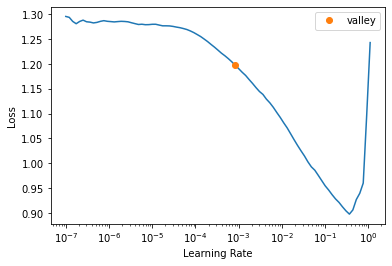

In [219]:
# Fastai has a useful function to estimate the best learning rate to use.
learn_tab.lr_find()

In [220]:
# Fit the data. We are not fine-tuning here. We are learning from our training data alone.
learn_tab.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.537413,0.770312,0.726088,00:05
1,0.387218,1.062577,0.732909,00:05
2,0.352577,1.069417,0.718311,00:05
3,0.318735,1.123301,0.733351,00:05
4,0.308855,0.992836,0.732296,00:05


In [221]:
tab_test_df = testing_df[X_cols].copy()
tab_test_dl = learn_tab.dls.test_dl(tab_test_df,ordered=True)

In [222]:
preds, _, decoded = learn_tab.get_preds(dl=tab_test_dl, with_decoded=True)

In [223]:
decoded

tensor([2, 2, 2,  ..., 2, 2, 2])

In [224]:
decoded.unique()

tensor([0, 1, 2])

In [225]:
decoded[decoded == 0] = -1
decoded[decoded == 1] = 0
decoded[decoded == 2] = 1

In [226]:
decoded.unique()

tensor([-1,  0,  1])

In [227]:
f1_score(testing_df[y_col],decoded,average="weighted")

0.6423349568038629

### HuggingFace Transformer
We were interested if formatting the inputs as a string and put through a transformer would work.
Based on tutorials by Jeremy Howard: https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/

In [8]:
%%time
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

CPU times: user 233 ms, sys: 11 ms, total: 244 ms
Wall time: 246 ms


In [9]:
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [10]:
dl_model_name = 'microsoft/deberta-v3-small'

In [11]:
tokz = AutoTokenizer.from_pretrained(dl_model_name)

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
sep = tokz.sep_token
sep

'[SEP]'

In [14]:
training_df.head(1)

,id,fetch_date,uploader,upload_date,title,desc_text,category,duration,age_limit,view_count,...,desc_neu,desc_neg,desc_pos,desc_compound,video_id,votes,comment_neg,comment_neu,comment_pos,comment_compound
0,FyDBw6Cq6-4,2019-02-03 05:06:14,ЛюбительМира,2018-11-23,WARFACE: КЛАН ХэвиРэйн МЫ ВОШЛИ В ТОП 10 СЕРВЕРА АЛЬФА✅,поддержка каналаговорящий донат от 20р заказ музыки от 100р httpdonatepayrudlyubitelmira начни играть в warface с донатом бесплатно httpfasst9ejljd золотой кейс за регистрацию в warface httpfasstxvuge1 комплект оружия неон и vip ускоритель httpfasstlm4qzwздравствуй дорогой зритель я рад тебя видеть меня зовут геворг ниже есть много информация про меня и не только добра тебе будь здороваприятного просмотраконтакты авторая вконтакте httpsvkcomid182830840моя группа vk httpsvkcomwarfaceloveworldгруппа моего клана в вк httpsvkcomwhitesharkrgwмой instagram httpswwwinstagramcomgevkaramyanразбл...,Gaming,6852,0,3380,...,0.97,0.00,0.03,0.51,0,0.00,0.00,0.00,0.00,0.00


In [15]:
X_cols

['duration',
 'age_limit',
 'view_count',
 'like_count',
 'view_like_ratio',
 'is_comments_enabled',
 'is_live_content',
 'cat_codes',
 'desc_compound',
 'comment_compound',
 'votes']

In [30]:
training_df[training_df["view_like_ratio"].round(2) < 1][["view_like_ratio","view_count","like_count"]].head()

,view_like_ratio,view_count,like_count
4,0.00,11,0
6,0.00,310,0
11,0.00,54,0
13,0.00,1346,0
28,0.00,1611,0


In [16]:
training_df['inputs'] = training_df.duration.str + sep + training_df.age_limit.str + sep + training_df.view_count + sep + training_df.like_count + sep + training_df.view_like_ratio + sep + training_df.is_comments_enabled + sep + training_df.is_live_content + sep + training_df.cat_codes + sep + training_df.desc_compound + sep + training_df.comment_compound + sep + training_df.votes

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U5')) -> None